<a href="https://colab.research.google.com/github/GeorgeTsio/MachineLearning_ToyProblems/blob/main/Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Load the libraries and set device agnostic code

In [27]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics.classification import BinaryAccuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

###1. Create the dataset `make_moons` and visualize it

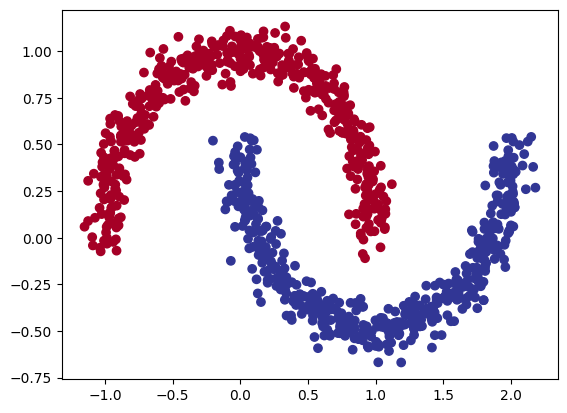

In [5]:
NUM_SAMPLES = 1000
RANDOM_STATE = 42

X, y = make_moons(n_samples=NUM_SAMPLES, noise=0.07, random_state=RANDOM_STATE)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

### 2. Turn data into tensors and split to train and test set

In [30]:
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)

X_train , X_test, y_train, y_test = train_test_split(X_tensor,
                                                     y_tensor,
                                                     test_size=0.2,
                                                     random_state=RANDOM_STATE)


print(f"Train data length: {len(X_train)}\nTrain labels: {len(y_train)}")
print(f"Test data length: {len(X_test)}\nTest labels: {len(y_test)}")

Train data length: 800
Train labels: 800
Test data length: 200
Test labels: 200


### 3. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data

In [31]:
class BinaryClassification(nn.Module):
  def __init__(self, in_features, hidden_units ,out_features):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [32]:
# Create an instance of that model and send it to target device
binary_model = BinaryClassification(in_features=2,
                                    hidden_units=10,
                                    out_features=1).to(device)

### 4. Setup a loss function, an accuracy function and an optimizer for the training step

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = BinaryAccuracy()
optimizer = torch.optim.SGD(params=binary_model.parameters(), # what to optimize
                            lr=0.1) # learning rate

### 5. Train and test loop

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Send datasets to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ###Training
  binary_model.train()

  # 1. Forward pass
  y_logits = binary_model(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train.int())

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ###Testing
  binary_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = binary_model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")



Epoch: 0 | Loss: 0.39 Acc: 0.82 | Test loss: 0.40 Test acc: 0.76
Epoch: 100 | Loss: 0.24 Acc: 0.88 | Test loss: 0.24 Test acc: 0.89
Epoch: 200 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.94
Epoch: 300 | Loss: 0.17 Acc: 0.93 | Test loss: 0.15 Test acc: 0.94
Epoch: 400 | Loss: 0.12 Acc: 0.95 | Test loss: 0.11 Test acc: 0.96
Epoch: 500 | Loss: 0.08 Acc: 0.98 | Test loss: 0.07 Test acc: 0.99
Epoch: 600 | Loss: 0.06 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 700 | Loss: 0.04 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 800 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00


### 6. Let's visualize how good our model fit the data

In [37]:
# Plot the model predictions
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

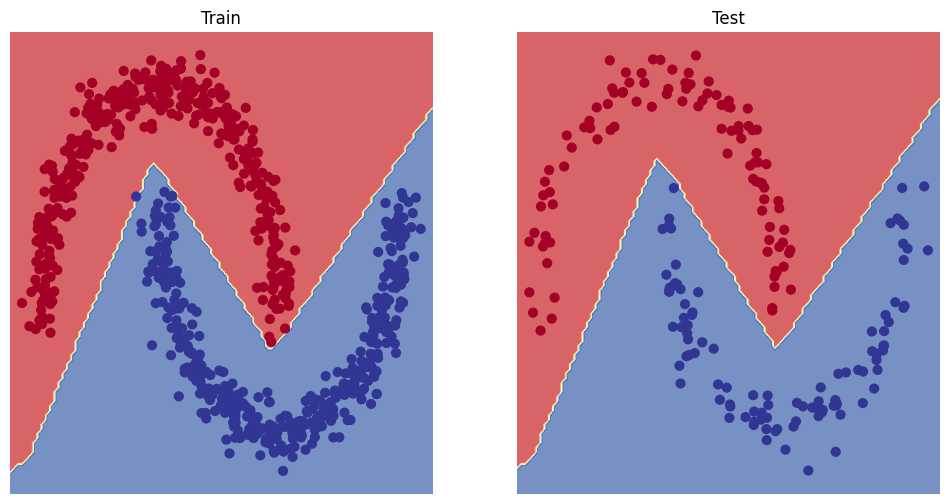

In [41]:
# Plot decision boundaries for test and training sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(binary_model, X_train, y_train)
plt.axis(False)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(binary_model, X_test, y_test)
plt.axis(False);